<a href="https://colab.research.google.com/github/shahriarivari/Diabete_RL/blob/main/custom_cbl/custom_cbl_neuralnetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#some pip installs

In [1]:
!pip install xgboost bayesian-optimization scikit-learn scikit-optimize jdatetime category_encoders

#Data import and preparation

In [2]:
import numpy as np
import pandas as pd
# Read the Excel file
df = pd.read_excel('datapost401402.xlsx')

In [3]:
# Assuming df is your DataFrame and 'old_column_name' is the name of the column you want to rename
df.rename(columns={'PGDS Code': 'PGDS_Code'}, inplace=True)

In [4]:
from datetime import datetime
import jdatetime    # to convert the the datatime to Gregorian

# Apply the conversion directly using a lambda function
df['Date'] = df['Date'].apply(lambda x: jdatetime.datetime.strptime(x, '%Y/%m/%d').togregorian().strftime('%Y-%m-%d'))

# Convert Jalali dates to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

## Scaling and dropping the unecessary columns

In [17]:
from utills import scale_df

# scaling the data frame
the_scaler , sacled_df =  scale_df(df = df.drop(['h1', 'h2', 'h3', 'h4','h5', 'h6'], axis =1),
                                   cols_to_scale_list = ['h7', 'h8', 'h9', 'h10',
                                                         'h12', 'h13','h14', 'h15',
                                                         'h16', 'h17', 'h11', 'h18',
                                                         'h19','h20', 'h21', 'h22',
                                                         'h23', 'h24'])

In [9]:
print(f"columns incuding in scaled data --> {sacled_df.columns.values}")

columns incuding in scaled data --> ['PGDS_Code' 'Date' 'h7' 'h8' 'h9' 'h10' 'h11' 'h12' 'h13' 'h14' 'h15'
 'h16' 'h17' 'h18' 'h19' 'h20' 'h21' 'h22' 'h23' 'h24']


## Applying necessary filters

In [21]:
from utills import filter_on_post_code, filter_days, add_time_feature, split_data_frames
from utills import filter_between_dates, convert_dates_to_pd_datetime
import category_encoders as ce

sacled_df_copy = sacled_df.copy()

# adding time features to the input
sacled_df_copy = add_time_feature(df = sacled_df_copy , date_col = "Date" )

# filtering input and target based on the post code
posts_to_filter_list = ["RBAZ"]
filtered_df = filter_on_post_code(df = sacled_df_copy, col_name = 'PGDS_Code', post_codes = posts_to_filter_list)

if not len(posts_to_filter_list) ==1 :

  binary_encoder = ce.BinaryEncoder(cols=['PGDS_Code'])
  filtered_df = binary_encoder.fit_transform(filtered_df)
else:
  filtered_df.drop("PGDS_Code",axis =1, inplace = True)
#_________________________________________________________________________
# # FILTER USING Date periods
desired_dates = [
    ("1400/07/11", "1400/08/11"),
    ("1401/07/11", "1401/07/30")
]
# convert the dates to Gregorian and as pd.datetime format
converted_date_periods = convert_dates_to_pd_datetime(list_of_dates = desired_dates)
# filter between desired dates
test_df = filter_between_dates(df = filtered_df , date_periods = converted_date_periods)
#_________________________________________________________________________
# FILTER USING DAYS
# seperate summer days
# start_day = 172  # June 21st
# end_day = 264    # September 23rd

# # Filtering the summer days for testing
# test_df = filter_days(df = filtered_df, date_col = "Date", start_day = start_day, end_day = end_day)


# split data frames
train_df = split_data_frames(df1 = filtered_df, df2= test_df)

<ipython-input-21-04467dd6ac40>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop("PGDS_Code",axis =1, inplace = True)


#Pytorch Neural Network model

In [13]:
# Standard PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##Data Preparation

##Splitting and converting data into torch tensors

In [14]:
X_train = input_splited_dataframe.drop(['PGDS_Code', 'Date'],axis = 1).values
X_test = input_filtered_df.drop(['PGDS_Code', 'Date'],axis = 1).values

y_train = target_splited_dataframe.drop(['PGDS_Code', 'Date'],axis = 1).values
y_test = target_filtered_df.drop(['PGDS_Code', 'Date'],axis = 1).values

In [37]:
X_train.shape

(493, 14)

In [38]:
X_test.shape

(51, 14)

In [15]:
# convert the data to a PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32)

# Convert training data to PyTorch DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=False)

##Constructing the model

In [27]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_units_list: list):
    super().__init__()
    layers = []

    # Add input layer
    layers.append(nn.Linear(input_size, hidden_units_list[0]))
    layers.append(nn.ReLU())
    # layers.append(nn.Dropout(p=0.1))

    # Add hidden layers
    for i in range(1, len(hidden_units_list)):
      layers.append(nn.Linear(hidden_units_list[i - 1], hidden_units_list[i]))
      layers.append(nn.ReLU())
      #layers.append(nn.Dropout(p=0.2))

    # Add output layer
    layers.append(nn.Linear(hidden_units_list[-1], output_size))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

##Making a grid
Making a grid to train multiple networks

In [17]:
param_grid = {
  'hidden_units_list': [[4],[8],[16],[32],
                        [4,4], [8,8],[8,4],
                        [16, 4], [16, 8],
                        ],
  'learning_rate': [0.001, 0.01]
}

##Train the model using different hyperparameters

In [28]:
from train_functions import train_step, test_step, train

# for loop to search the parameter space for the best parameters
# Convert test data to PyTorch tensor

test_data = (X_test_tensor, y_test_tensor)
counter = 1
models_results_list = []

for params in ParameterGrid(param_grid):
  print(f"{counter} set of params in total of {len(ParameterGrid(param_grid))}")

  model_parameters = params.copy()  # Create a copy of params to avoid modifying the original dictionary
  learning_rate = params['learning_rate']
  del params['learning_rate']  # Remove learning_rate from params
  # Set a random seed for reproducibility
  torch.manual_seed(42)
  model = NeuralNetwork(input_size=X_train_tensor.shape[1],output_size = y_train_tensor.shape[1], **params).to(device)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # train the model
  results = train(model=model,
                  train_dataloader = train_loader,
                  test_data = test_data,
                  optimizer = optimizer,
                  criterion = criterion,
                  epochs = 20,
                  device = device)

  # calculate the test loss
  # Put model in eval mode
  model.eval()
  # Turn on inference context manager
  with torch.inference_mode():

    X, y = test_data
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # Calculate and accumulate loss
    loss = criterion(y_pred, y)
    test_loss = loss.item()

  model_results = {
    "model_parameters": model_parameters,
    "train_loss": results["train_loss"],
    "eval_loss": results["test_loss"],
    "test_loss": test_loss
  }
  models_results_list.append(model_results)

  counter +=1

1 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

2 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

3 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

4 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

5 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

6 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

7 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

8 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

9 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

10 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

11 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

12 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

13 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

14 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

15 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

16 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

17 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

18 set of params in total of 18


  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
# find the best model that didnt overfit
non_overfitting_model_indices = [] # Lists to store indices of models that didn't overfit

# Iterate through models_results_list
for i, model_results in enumerate(models_results_list):
  model_parameters = model_results["model_parameters"]
  train_loss = model_results["train_loss"]
  eval_loss = model_results["eval_loss"]

  # Check if the eval loss is greater than the train loss
  if all(x > y for x, y in zip(eval_loss[-5:], train_loss[-5:])):
    non_overfitting_model_indices.append(i)

if not non_overfitting_model_indices:
  print("all models overfitted")
else:
  # Compare test losses for non-overfitting models
  test_losses = [models_results_list[i]["test_loss"] for i in non_overfitting_model_indices]
  # Select the best model index with the lowest test losses
  best_test_loss_index = sorted(range(len(test_losses)), key=lambda k: test_losses[k])[0]
  best_model_index = non_overfitting_model_indices[best_test_loss_index]
  print("model's parameters",models_results_list[best_model_index]["model_parameters"] )
  print("test loss",models_results_list[best_model_index]["test_loss"])

model's parameters {'hidden_units_list': [32], 'learning_rate': 0.01}
test loss 0.0005646462668664753


###Now lets train the best model

In [30]:
best_model_parameters = models_results_list[best_model_index].copy()  # Create a copy of params to avoid modifying the original dictionary
learning_rate = best_model_parameters["model_parameters"]['learning_rate']
del best_model_parameters["model_parameters"]['learning_rate']  # Remove learning_rate from params

ann_model = NeuralNetwork(input_size=X_train_tensor.shape[1],output_size = y_train_tensor.shape[1]
                          , **best_model_parameters["model_parameters"]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ann_model.parameters(), lr=learning_rate)

# train the model
results = train(model=ann_model,
                train_dataloader = train_loader,
                test_data = test_data,
                optimizer = optimizer,
                criterion = criterion,
                epochs = 150,
                device = device)

# calculate the test loss

# Put model in eval mode
ann_model.eval()
# Turn on inference context manager
with torch.inference_mode():

  X, y = test_data
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Forward pass
  y_pred = ann_model(X)

  # Calculate and accumulate loss
  loss = criterion(y_pred, y)
  test_loss = loss.item()

print("test loss is ",test_loss)

  0%|          | 0/150 [00:00<?, ?it/s]

test loss is  0.00018594339780975133


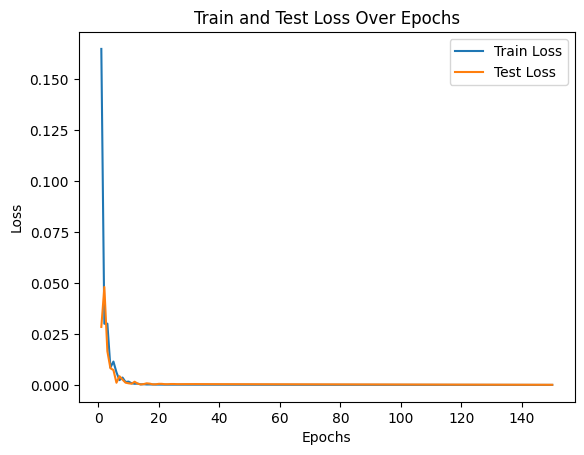

In [31]:
from train_functions import plot_perfomance_results

plot_perfomance_results(results)

##Making prediction using the best model

In [32]:
# predictions for X_test
# Turn on inference context manager
with torch.inference_mode():
  X, y = test_data
  # Send data to target device
  X, y = X.to(device), y.to(device)
  # Forward pass
  y_test_pred = ann_model(X)

ann_testset_prediction = (y_test_pred.detach().cpu().numpy())
actual_test_values = y_test_tensor.detach().cpu().numpy()
ann_testset_MSE_error = mean_squared_error(actual_test_values, ann_testset_prediction)
print(f"Model Error for test set: {ann_testset_MSE_error}")

# predictions for X_train
# Turn on inference context manager
with torch.inference_mode():
  X, y = (X_train_tensor, y_train_tensor)
  # Send data to target device
  X, y = X.to(device), y.to(device)
  # Forward pass
  y_train_pred = ann_model(X)

ann_trainset_prediction = (y_train_pred.detach().cpu().numpy())
actual_train_values = y_train_tensor.detach().cpu().numpy()
ann_trainset_MSE_error = mean_squared_error(actual_train_values, ann_trainset_prediction)
print(f"Model Error for train set: {ann_trainset_MSE_error}")

Model Error for test set: 0.00018594336870592088
Model Error for train set: 0.00011920293763978407


###Unscaling and predicting

In [33]:
# Unscale predictions and y_test to plot
ann_y_pred_unscaled = tragert_scaler.inverse_transform(ann_testset_prediction)
y_test_unscaled = tragert_scaler.inverse_transform(actual_test_values)

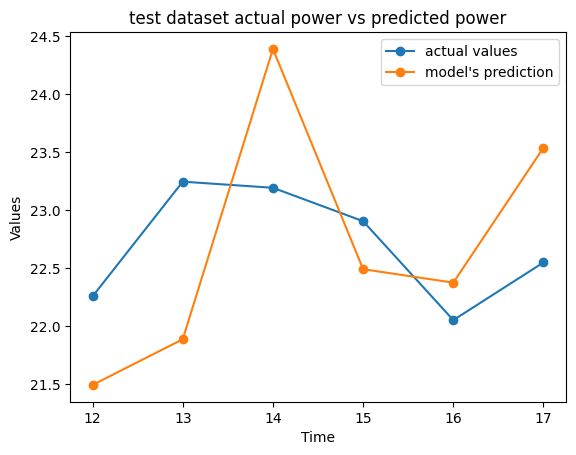

In [36]:
# plot the best model's prediction vs the actual values
import matplotlib.pyplot as plt
day = 33
plt.figure()
# Plotting actual values against Time
plt.plot([12,13,14,15,16,17],y_test_unscaled[day], marker='o', linestyle='-', label = "actual values")
# Plotting predictions against Time
plt.plot([12,13,14,15,16,17],ann_y_pred_unscaled[day], marker='o', linestyle='-', label = "model's prediction")

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
# Adding a legend
plt.legend()
# Show the plot
plt.show()

#Ensemble methods


##1- Random Forest

###Initial imports

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

###Function to train an Random Forest model and hyperparameter tuning while training

In [ ]:
def find_rf_model(X, y, init_points=10, n_iter=20):
  # Function to train a Random Forest regressor with Bayesian Optimization for hyperparameter tuning
  def rf_cv(X,y,n_estimators, max_depth, min_samples_split, min_samples_leaf):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 42
    }

    model = RandomForestRegressor(**params)
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

  # Bayesian Optimization
  rf_bo = BayesianOptimization(
    lambda n_estimators, max_depth, min_samples_split, min_samples_leaf: rf_cv(X, y, n_estimators, max_depth, min_samples_split, min_samples_leaf),
    {'n_estimators': (50, 200),
      'max_depth': (3, 20),
      'min_samples_split': (2, 20),
      'min_samples_leaf': (1, 10)}
  )

  rf_bo.maximize(init_points=init_points, n_iter=n_iter)

  # Get the best hyperparameters
  best_params_rf = rf_bo.max['params']
  best_params_rf['n_estimators'] = int(best_params_rf['n_estimators'])
  best_params_rf['max_depth'] = int(best_params_rf['max_depth'])
  best_params_rf['min_samples_split'] = int(best_params_rf['min_samples_split'])
  best_params_rf['min_samples_leaf'] = int(best_params_rf['min_samples_leaf'])

  # Train the final Random Forest model with the best hyperparameters
  final_model = RandomForestRegressor(**best_params_rf)

  return final_model

###Training and predicting on X_test

In [ ]:
rf_model = find_rf_model(X_train,y_train)
rf_model.fit(X_train, y_train)

# predictions for X_test
rf_testset_predictions = rf_model.predict(X_test)
rf_testset_MSE_error = mean_squared_error(y_test, rf_testset_predictions)
print(f"Model Error for test set: {rf_testset_MSE_error}")

# predictions for X_train
rf_trainset_predictions = rf_model.predict(X_train)
rf_trainset_MSE_error = mean_squared_error(y_train, rf_trainset_predictions)
print(f"Model Error for train set: {rf_trainset_MSE_error}")

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.000314 | 4.872     | 4.638     | 18.5      | 166.6     |
| 2         | -0.000321 | 14.86     | 9.343     | 19.73     | 173.5     |
| 3         | -0.000342 | 3.16      | 8.271     | 16.39     | 197.2     |
| 4         | -0.000311 | 9.393     | 8.315     | 11.86     | 90.94     |
| 5         | -0.000279 | 19.54     | 3.573     | 7.587     | 137.6     |
| 6         | -0.000275 | 13.26     | 2.203     | 5.569     | 162.4     |
| 7         | -0.000284 | 13.75     | 4.776     | 7.741     | 192.7     |
| 8         | -0.000287 | 12.08     | 4.834     | 2.758     | 62.21     |
| 9         | -0.000292 | 9.001     | 1.558     | 15.0      | 161.6     |
| 10        | -0.000293 | 6.943     | 2.989     | 15.83     | 145.5     |
| 11        | -0.000295 | 18.59     | 1.172     | 16.59     | 89.68     |
| 12        | -0.000337 | 3.089     | 

###Unscaling and plotting

In [ ]:
# Unscale predictions and y_test to plot
rf_y_pred_unscaled = tragert_scaler.inverse_transform(rf_testset_predictions)
y_test_unscaled = tragert_scaler.inverse_transform(y_test)

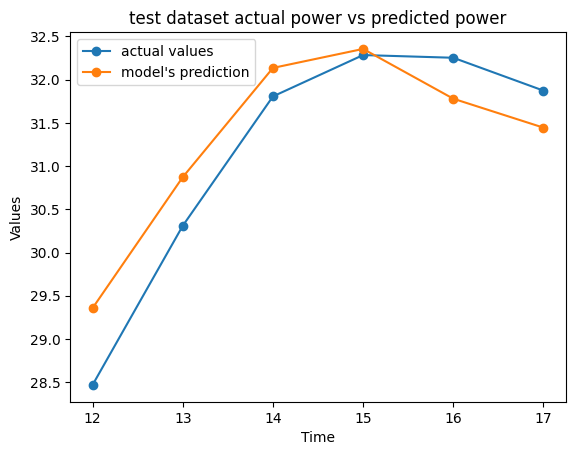

In [ ]:
import matplotlib.pyplot as plt
day = 18
plt.figure()
# Plotting actual values against Time
plt.plot([12,13,14,15,16,17],y_test_unscaled[day], marker='o', linestyle='-', label = "actual values")
# Plotting predictions against Time
plt.plot([12,13,14,15,16,17],rf_y_pred_unscaled[day], marker='o', linestyle='-', label = "model's prediction")

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
# Adding a legend
plt.legend()
# Show the plot
plt.show()

##2- XGBoost model

###Initial imports

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization

###Function to train an XGBoost model and hyperparameter tuning while training

In [ ]:
# Function to train an XGBoost model with Bayesian Optimization for hyperparameter tuning
def find_xgb_model(X, y, init_points=10, n_iter=20):
  def xgb_cv(learning_rate, max_depth, subsample, colsample_bytree, n_estimators):
    params = {
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'subsample': max(min(subsample, 1), 0),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'n_estimators': int(n_estimators),
        'objective': 'reg:squarederror',  # For regression tasks
    }
    model = XGBRegressor(**params)
    scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_squared_error')
    return np.mean(scores)

  # Bayesian Optimization
  xgb_bo = BayesianOptimization(xgb_cv, {'learning_rate': (0.01, 0.1),
                                          'max_depth': (5, 20),
                                          'subsample': (0.8, 1),
                                          'colsample_bytree': (0.8, 1),
                                          'n_estimators': (50, 150)})

  xgb_bo.maximize(init_points=init_points, n_iter=n_iter)

  # Get the best hyperparameters
  best_params = xgb_bo.max['params']
  for param_name in ['learning_rate', 'max_depth', 'subsample', 'colsample_bytree', 'n_estimators']:
    best_params[param_name] = best_params[param_name]

  # Convert max_depth and n_estimators to integers
  best_params['max_depth'] = int(best_params['max_depth'])
  best_params['n_estimators'] = int(best_params['n_estimators'])

  # Train the final model with the best hyperparameters
  final_model = XGBRegressor(**best_params)

  return final_model

###Training and predicting on X_test

In [ ]:
# Train XGBoost model
xgb_model = find_xgb_model(X_train, y_train)
xgb_model.fit(X_train, y_train)

# predictions for X_test
xgb_testset_predictions = xgb_model.predict(X_test)
xgb_testset_MSE_error = mean_squared_error(y_test, xgb_testset_predictions)
print(f"Model Error for test set: {xgb_testset_MSE_error}")

# predictions for X_train
xgb_trainset_predictions = xgb_model.predict(X_train)
xgb_trainset_MSE_error = mean_squared_error(y_train, xgb_trainset_predictions)
print(f"Model Error for train set: {xgb_trainset_MSE_error}")

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.000637 | 0.9456    | 0.06143   | 14.15     | 70.73     | 0.84      |
| 2         | -0.000636 | 0.8802    | 0.0797    | 10.74     | 141.5     | 0.8829    |
| 3         | -0.000626 | 0.8705    | 0.06867   | 17.47     | 66.86     | 0.8741    |
| 4         | -0.0011   | 0.9865    | 0.02055   | 19.24     | 111.6     | 0.9934    |
| 5         | -0.000632 | 0.9187    | 0.0994    | 12.83     | 92.42     | 0.8721    |
| 6         | -0.000640 | 0.9216    | 0.06375   | 6.498     | 103.5     | 0.9963    |
| 7         | -0.000604 | 0.9029    | 0.08685   | 5.723     | 136.8     | 0.8257    |
| 8         | -0.000625 | 0.9194    | 0.08205   | 17.22     | 64.8      | 0.8535    |
| 9         | -0.000618 | 0.8104    | 0.0518    | 19.76     | 131.2     | 0.843     |
| 10        | -0.000621 | 0.8544    | 0.09783   | 7.11

###Unscaling and plotting

In [ ]:
# Unscale predictions and y_test to plot
xgb_y_pred_unscaled = y_scaler.inverse_transform(xgb_testset_predictions)
y_test_unscaled = y_scaler.inverse_transform(y_test)

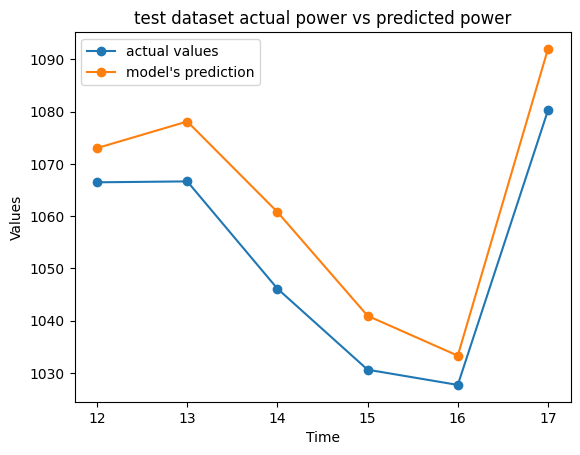

In [ ]:
import matplotlib.pyplot as plt
day = 18
plt.figure()
# Plotting actual values against Time
plt.plot([12,13,14,15,16,17],y_test_unscaled[day], marker='o', linestyle='-', label = "actual values")
# Plotting predictions against Time
plt.plot([12,13,14,15,16,17],xgb_y_pred_unscaled[day], marker='o', linestyle='-', label = "model's prediction")

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
# Adding a legend
plt.legend()
# Show the plot
plt.show()

#SVR model

###Initial Imports

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import MultiOutputRegressor
from bayes_opt import BayesianOptimization
import numpy as np

###Function to train an Random Forest model and hyperparameter tuning while training

In [ ]:
# Function to train an SVR model with Bayesian Optimization for hyperparameter tuning
def find_svr_model(X, y, init_points=10, n_iter=20):

  kernel_options = ['linear', 'poly', 'rbf', 'sigmoid']

  def svr_cv(C, kernel, degree, gamma, epsilon):
    kernel_index = int(np.round(kernel))  # Round to the nearest integer
    selected_kernel = kernel_options[kernel_index]

    svr_params = {
        'C': C,
        'kernel': selected_kernel,
        'degree': int(degree),
        'gamma': gamma,
        'epsilon': epsilon
    }

    svr_model = SVR(**svr_params)
    multioutput_svr = MultiOutputRegressor(svr_model)

    # Use cross_val_score with multioutput_svr
    scores = cross_val_score(multioutput_svr, X, y, cv=3, scoring='neg_mean_squared_error')
    return np.mean(scores)

  # Bayesian Optimization
  svr_bo = BayesianOptimization(
      svr_cv,
      pbounds={'C': (1e-6, 1e+6),
                'kernel': (0, 3),  # Representing the indices of ['linear', 'poly', 'rbf', 'sigmoid']
                'degree': (1, 5),
                'gamma': (1e-6, 1e+1),
                'epsilon': (1e-6, 1e+1)},
      random_state=42
  )

  svr_bo.maximize(init_points=init_points, n_iter=n_iter)

  # Get the best hyperparameters
  best_params = svr_bo.max['params']
  for param_name in ['C', 'kernel', 'degree', 'gamma', 'epsilon']:
      best_params[param_name] = best_params[param_name]

  # Convert degree to an integer
  best_params['degree'] = int(best_params['degree'])

  # Map the 'kernel' parameter to a string representation
  best_params['kernel'] = kernel_options[int(np.round(best_params['kernel']))]

  # Train the final model with the best hyperparameters
  svr_model = SVR(**best_params)
  final_model = MultiOutputRegressor(svr_model)

  return final_model


###Training and predicting on X_test

In [ ]:
svr_model = find_svr_model(X_train, y_train)
svr_model.fit(X_train, y_train)

# predictions for X_test
svr_testset_predictions = svr_model.predict(X_test)
svr_testset_MSE_error = mean_squared_error(y_test, svr_testset_predictions)
print(f"Model Error for test set: {svr_testset_MSE_error}")

# predictions for X_train
svr_trainset_predictions = svr_model.predict(X_train)
svr_trainset_MSE_error = mean_squared_error(y_train, svr_trainset_predictions)
print(f"Model Error for train set: {svr_trainset_MSE_error}")

|   iter    |  target   |     C     |  degree   |  epsilon  |   gamma   |  kernel   |
-------------------------------------------------------------------------------------
| 1         | -0.03558  | 3.745e+05 | 4.803     | 7.32      | 5.987     | 0.4681    |
| 2         | -0.03558  | 1.56e+05  | 1.232     | 8.662     | 6.011     | 2.124     |
| 3         | -0.03558  | 2.058e+04 | 4.88      | 8.324     | 2.123     | 0.5455    |
| 4         | -0.03558  | 1.834e+05 | 2.217     | 5.248     | 4.319     | 0.8737    |
| 5         | -0.03558  | 6.119e+05 | 1.558     | 2.921     | 3.664     | 1.368     |
| 6         | -0.03558  | 7.852e+05 | 1.799     | 5.142     | 5.924     | 0.1394    |
| 7         | -0.03558  | 6.075e+05 | 1.682     | 0.6505    | 9.489     | 2.897     |
| 8         | -0.03558  | 8.084e+05 | 2.218     | 0.9767    | 6.842     | 1.32      |
| 9         | -0.01573  | 1.22e+05  | 2.981     | 0.3439    | 9.093     | 0.7763    |
| 10        | -0.03558  | 6.625e+05 | 2.247     | 5.20

###Unscaling and plotting

In [ ]:
# Unscale predictions and y_test to plot
svr_y_pred_unscaled = y_scaler.inverse_transform(svr_testset_predictions)
y_test_unscaled = y_scaler.inverse_transform(y_test)

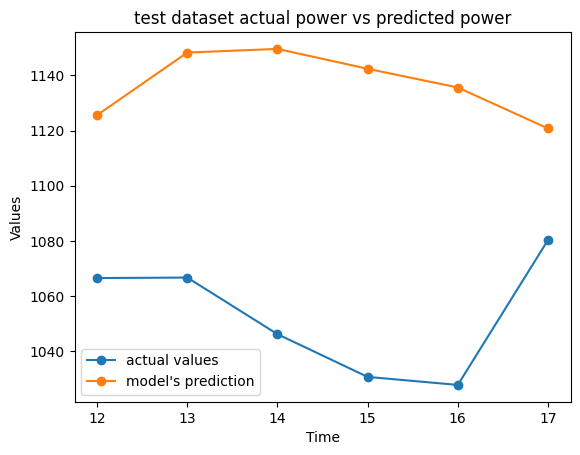

In [ ]:
import matplotlib.pyplot as plt
day = 18
plt.figure()
# Plotting actual values against Time
plt.plot([12,13,14,15,16,17],y_test_unscaled[day], marker='o', linestyle='-', label = "actual values")
# Plotting predictions against Time
plt.plot([12,13,14,15,16,17],svr_y_pred_unscaled[day], marker='o', linestyle='-', label = "model's prediction")

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
# Adding a legend
plt.legend()
# Show the plot
plt.show()

#Weighted Voting Regressor

###Initila imports

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

###Function to fit a Linear Regression model between our two RF and XGB model
In this section weare trying to make predictions by using our both models, by
assigning weight to each of our models predcitions

In [ ]:
# making a dict of our models' predictions
models_predictions = {
    'train': [ann_trainset_prediction, rf_trainset_predictions, xgb_trainset_predictions, svr_trainset_predictions],
    'test': [ann_testset_prediction, rf_testset_predictions, xgb_testset_predictions, svr_testset_predictions]
}

In [ ]:
def fit_weighted_voting_regressor(models_predictions:dict, y_train, y_test):
    # Extract training predictions from each model
    X_train_preds_combined = np.column_stack(models_predictions['train'])

    # Linear regression to learn weights
    lr_model = LinearRegression()
    lr_model.fit(X_train_preds_combined, y_train)

    # Extract test predictions from each model
    X_test_preds_combined = np.column_stack(models_predictions['test'])

    # Predictions from linear regression model
    y_pred_combined = lr_model.predict(X_test_preds_combined)

    # Evaluate the model
    mse_combined = mean_squared_error(y_test, y_pred_combined)
    print(f"Mean Squared Error of Combined Model on Test Set: {mse_combined}")

    # Return the trained linear regression model
    return lr_model

###Training and predicting on X_test

In [ ]:
# Create individual regressors
weighted_model = fit_weighted_voting_regressor(models_predictions, y_train, y_test)

Mean Squared Error of Combined Model on Test Set: 0.00041885696557693693


In [ ]:
def predict_weighted_voting_regressor(lr_model, input_data):

  # Concatenate predictions to use as features for linear regression
  input_combined = np.column_stack(input_data)

  # Predictions from linear regression model
  pred_combined = lr_model.predict(input_combined)

  return pred_combined

In [ ]:
# predictions for X_test
weighted_model_combined_testset_prediction = predict_weighted_voting_regressor( weighted_model, models_predictions["test"])
weighted_model_testset_MSE_error = mean_squared_error(y_test, weighted_model_combined_testset_prediction)
print(f"Model Error for test set: {weighted_model_testset_MSE_error}")

# predictions for X_test
weighted_model_combined_trainset_prediction = predict_weighted_voting_regressor(weighted_model, models_predictions["train"])
weighted_model_trainset_MSE_error = mean_squared_error(y_train, weighted_model_combined_trainset_prediction)
print(f"Model Error for test set: {weighted_model_trainset_MSE_error}")

Model Error for test set: 0.00041885696557693693
Model Error for test set: 2.3177437768300317e-05


###Unscaling and plotting

In [ ]:
# Unscale predictions and y_test to plot
weighted_model_y_pred_unscaled = y_scaler.inverse_transform(weighted_model_combined_testset_prediction)
y_test_unscaled = y_scaler.inverse_transform(y_test)

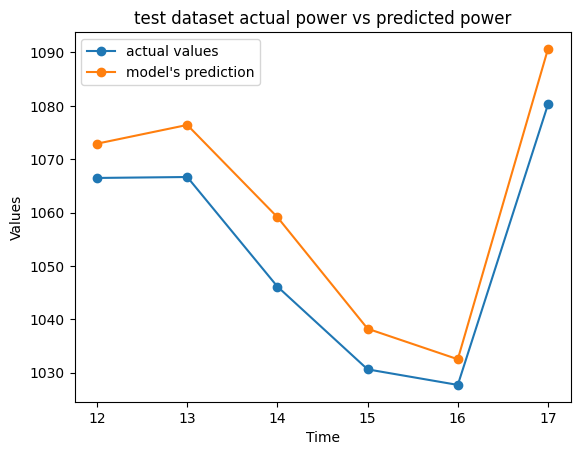

In [ ]:
import matplotlib.pyplot as plt
day = 18
plt.figure()
# Plotting actual values against Time
plt.plot([12,13,14,15,16,17],y_test_unscaled[day], marker='o', linestyle='-', label = "actual values")
# Plotting predictions against Time
plt.plot([12,13,14,15,16,17],weighted_model_y_pred_unscaled[day], marker='o', linestyle='-', label = "model's prediction")

plt.title('test dataset actual power vs predicted power')
plt.xlabel('Time')
plt.ylabel('Values')
# Adding a legend
plt.legend()
# Show the plot
plt.show()

#Compare models

In [ ]:
print(ann_testset_MSE_error)
print(rf_testset_MSE_error)
print(xgb_testset_MSE_error)
print(svr_testset_MSE_error)
print(weighted_model_testset_MSE_error)

0.0019442784
0.0005426047136385044
0.00044124873
0.010007859001443494
0.00041885696557693693


In [ ]:
models_dict = {"model names": ["ANN","Random Forest", "XGBoost", "SVR", "weighted combined models"],
               "Train set MSE error": [ann_trainset_MSE_error, rf_trainset_MSE_error, xgb_trainset_MSE_error,svr_trainset_MSE_error, weighted_model_trainset_MSE_error],
               "Test set MSE error": [ann_testset_MSE_error, rf_testset_MSE_error, xgb_testset_MSE_error,svr_testset_MSE_error, weighted_model_testset_MSE_error]
               }
# Convert the dictionary to a pandas DataFrame
model_df = pd.DataFrame(models_dict)
# model_df.to_excel('models.xlsx', index=False)

model_df

,model names,Train set MSE error,Test set MSE error
0,ANN,0.001937,0.001944
1,Random Forest,0.000069,0.000543
2,XGBoost,0.000037,0.000441
3,SVR,0.009930,0.010008
4,weighted combined models,0.000023,0.000419
